# Import Libary

In [59]:
# =========================
# IMPORT LIBARY ===========
# =========================

import pandas as pd # Import library untuk manipulating dataset
import seaborn as sns # Import library untuk visualisasi EDA
import numpy as np # Import library untuk manipulating number data
import tkinter as tk

from pandas.api.types import is_string_dtype, is_numeric_dtype # Import library untuk membaca type data column Dataframe
from matplotlib import pyplot as plt # Import library untuk Exploratory Data Analysis
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

from tkinter import * # Import library untuk pembuatan GUI
from tkinter import ttk # Import library turunan TKInter untuk tambahan widget dan component



# Load Datasets

In [60]:
data_path = 'datasets/diabetes_data_upload.csv' # membuat variable untuk menyimpan path data ke dataset
df = pd.read_csv(data_path) #membaca dataset dari variable data_path 
df.head() # menampilkan 5 data teratas

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [61]:
df.shape # cek dimensi data sebelum masuk pre-processing

(520, 17)

In [62]:
df.nunique() # mengecek data unik pada setiap kolom

Age                   51
Gender                 2
Polyuria               2
Polydipsia             2
sudden weight loss     2
weakness               2
Polyphagia             2
Genital thrush         2
visual blurring        2
Itching                2
Irritability           2
delayed healing        2
partial paresis        2
muscle stiffness       2
Alopecia               2
Obesity                2
class                  2
dtype: int64

In [63]:
df.info() # menampilkan informasi dari data frame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

# Duplicate Data Visualization

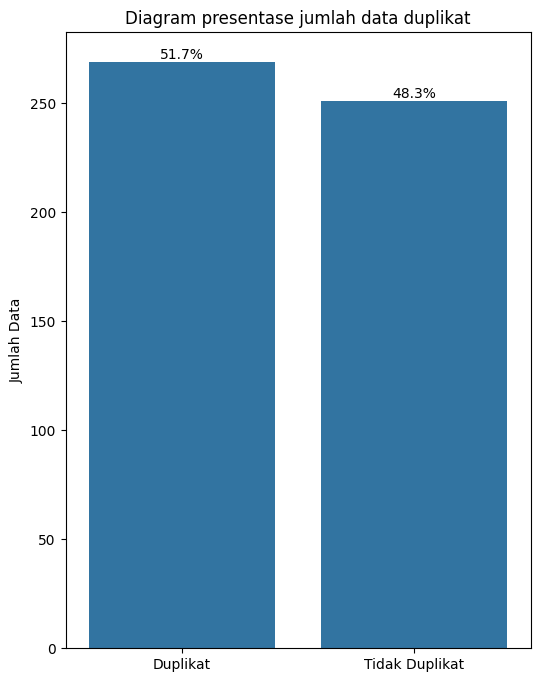

In [64]:
# barplot melihat jumlah data duplicate
plt.figure(figsize=(6, 8))
plt.title("Diagram presentase jumlah data duplikat")

count_duplicate = df.duplicated().sum()
non_duplicate = len(df) - count_duplicate
total = count_duplicate + non_duplicate

precentages = [
    count_duplicate / total * 100,
    non_duplicate / total * 100
    
]

res = sns.barplot(
    x=['Duplikat', 'Tidak Duplikat'],
    y=[count_duplicate, non_duplicate]
)

for i, p in enumerate(res.patches):
    res.text(
        p.get_x() + p.get_width() / 2,
        p.get_height(),
        f'{precentages[i]:.1f}%',
        ha='center',
        va='bottom'
    )

plt.ylabel("Jumlah Data")
plt.show()


# Data PreProcessing

In [65]:
# =====================
# DATA PREPROCESSING ==
# =====================

df.isna().sum() # mengecek data yang kosong
df.duplicated().sum() # mengecek data yang duplikat

np.int64(269)

In [66]:
df = df.drop_duplicates() # menghapus data duplikat dan melakukan reset index
df = df.fillna(df.mode().iloc[0])

In [67]:
df.shape #mengecek dimensi data setelah menghapus data duplikat

(251, 17)

In [68]:
df.nunique()

Age                   51
Gender                 2
Polyuria               2
Polydipsia             2
sudden weight loss     2
weakness               2
Polyphagia             2
Genital thrush         2
visual blurring        2
Itching                2
Irritability           2
delayed healing        2
partial paresis        2
muscle stiffness       2
Alopecia               2
Obesity                2
class                  2
dtype: int64

# Exploratory Data Analys (EDA)

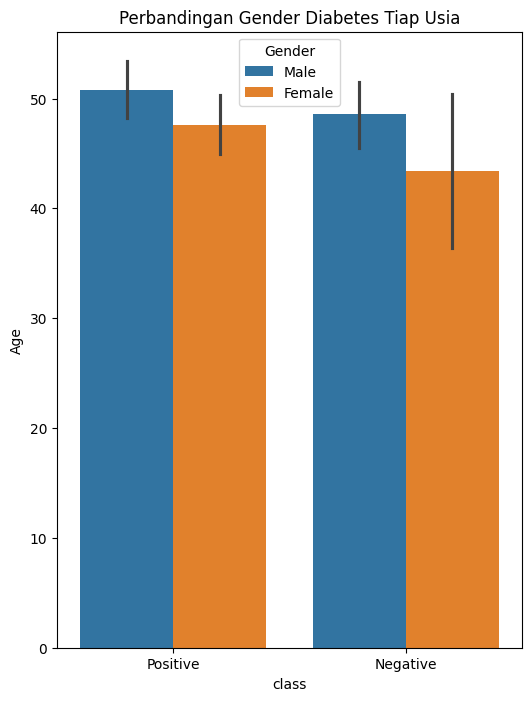

In [69]:
plt.figure(figsize=(6,8))
sns.barplot(data=df, y="Age", x="class", hue="Gender")
plt.title("Perbandingan Gender Diabetes Tiap Usia")
plt.show()

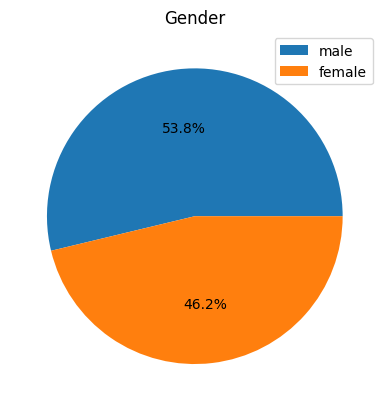

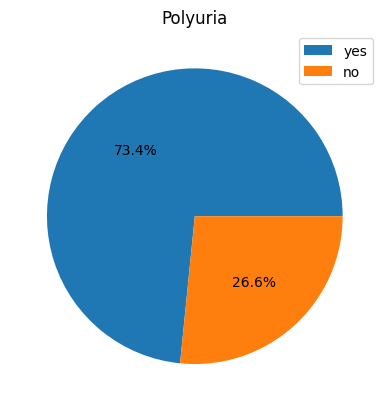

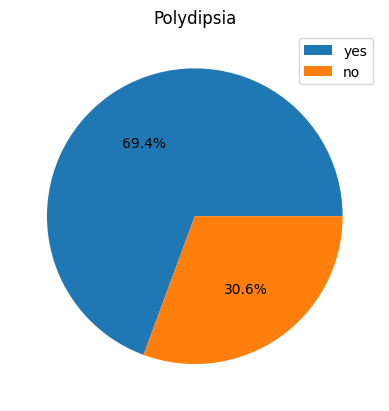

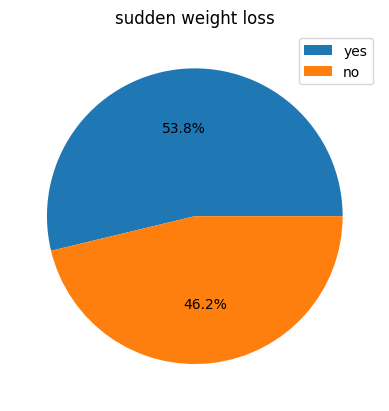

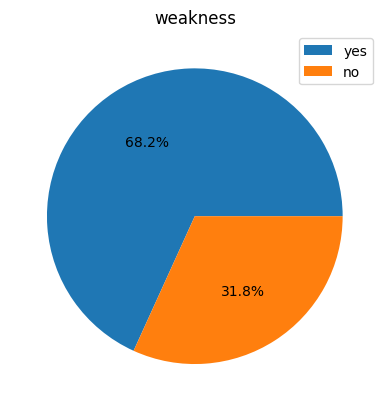

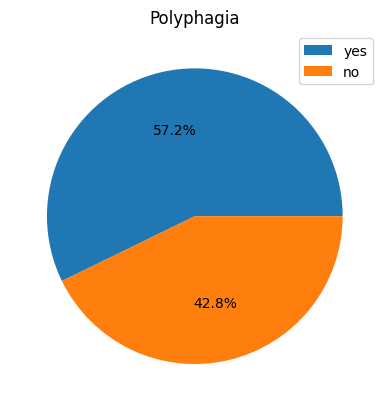

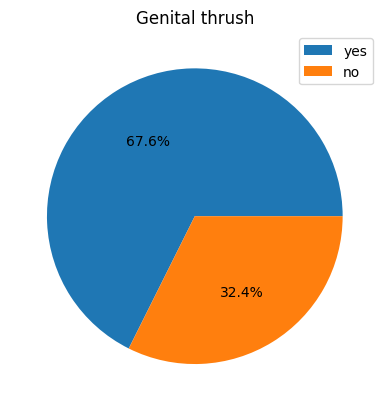

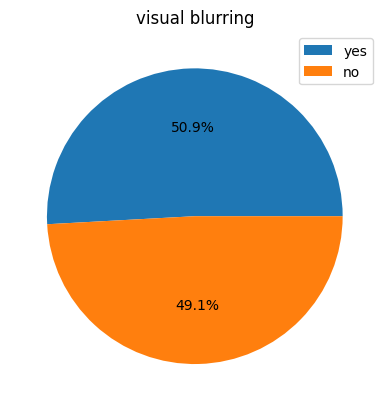

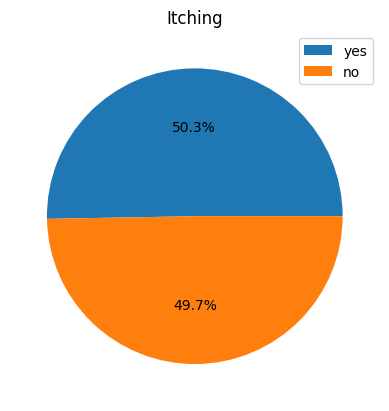

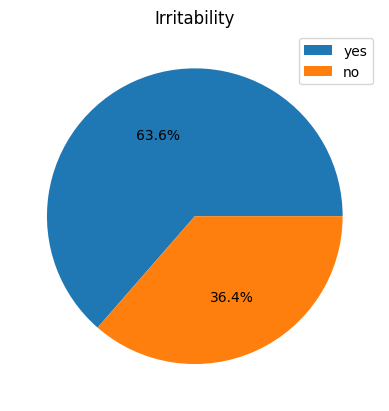

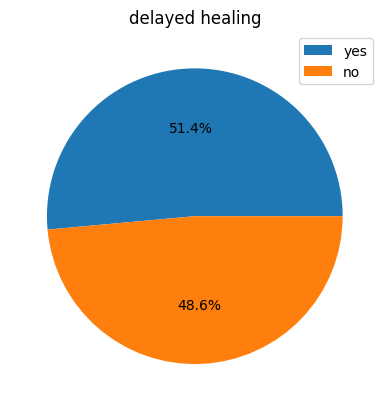

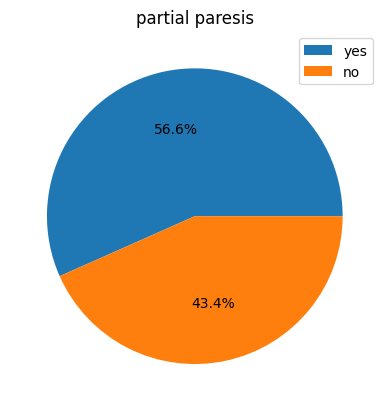

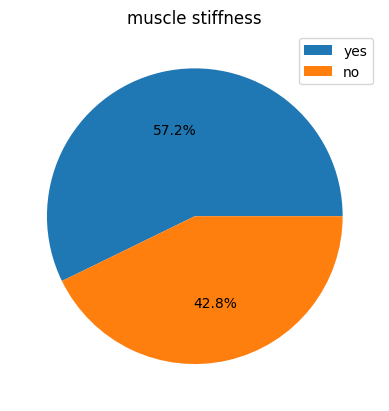

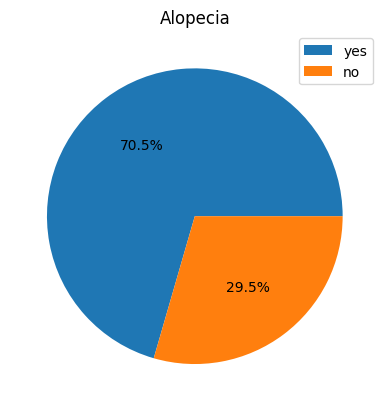

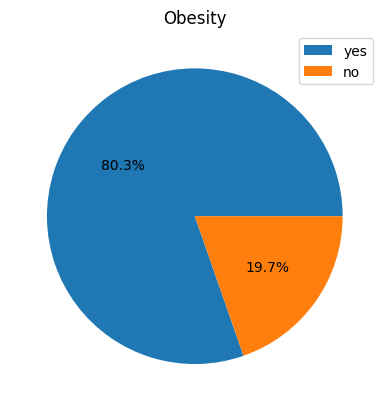

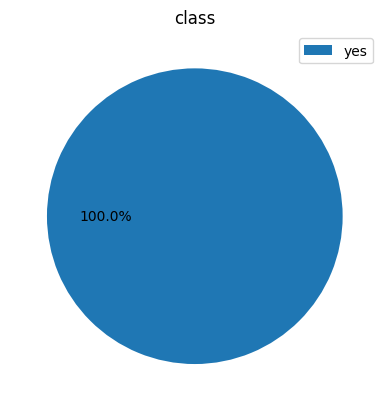

In [70]:
for x in df.select_dtypes(exclude=['int64']):
    count_positive = df[df['class'] == 'Positive'][x].value_counts()
    df.drop('class', axis=1)
    plt.pie(count_positive, autopct='%1.1f%%')
    legend = [
        'yes',
        'no'
    ]
    if x == 'Gender':
        legend = [
            'male',
            'female'
        ]
    plt.legend(legend) 
    plt.title(x)
    plt.show()

In [71]:
def encode_column(col): # membuat function untuk melakukan encoding data dengan variable unique
    unique_vals = col.unique()
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    return col.map(mapping)


for col in df.columns: # melakukan encoding data pada column variable df
    if df[col].dtype == "object":
        df[col] = encode_column(df[col])

df.columns = df.columns.str.lower().str.replace(' ', '_')

df.head()


,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,58,0,0,1,0,0,0,0,1,1,0,1,1,1,0,1,0
2,41,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0
3,45,0,0,1,1,0,1,1,0,0,0,0,0,1,1,1,0
4,60,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0


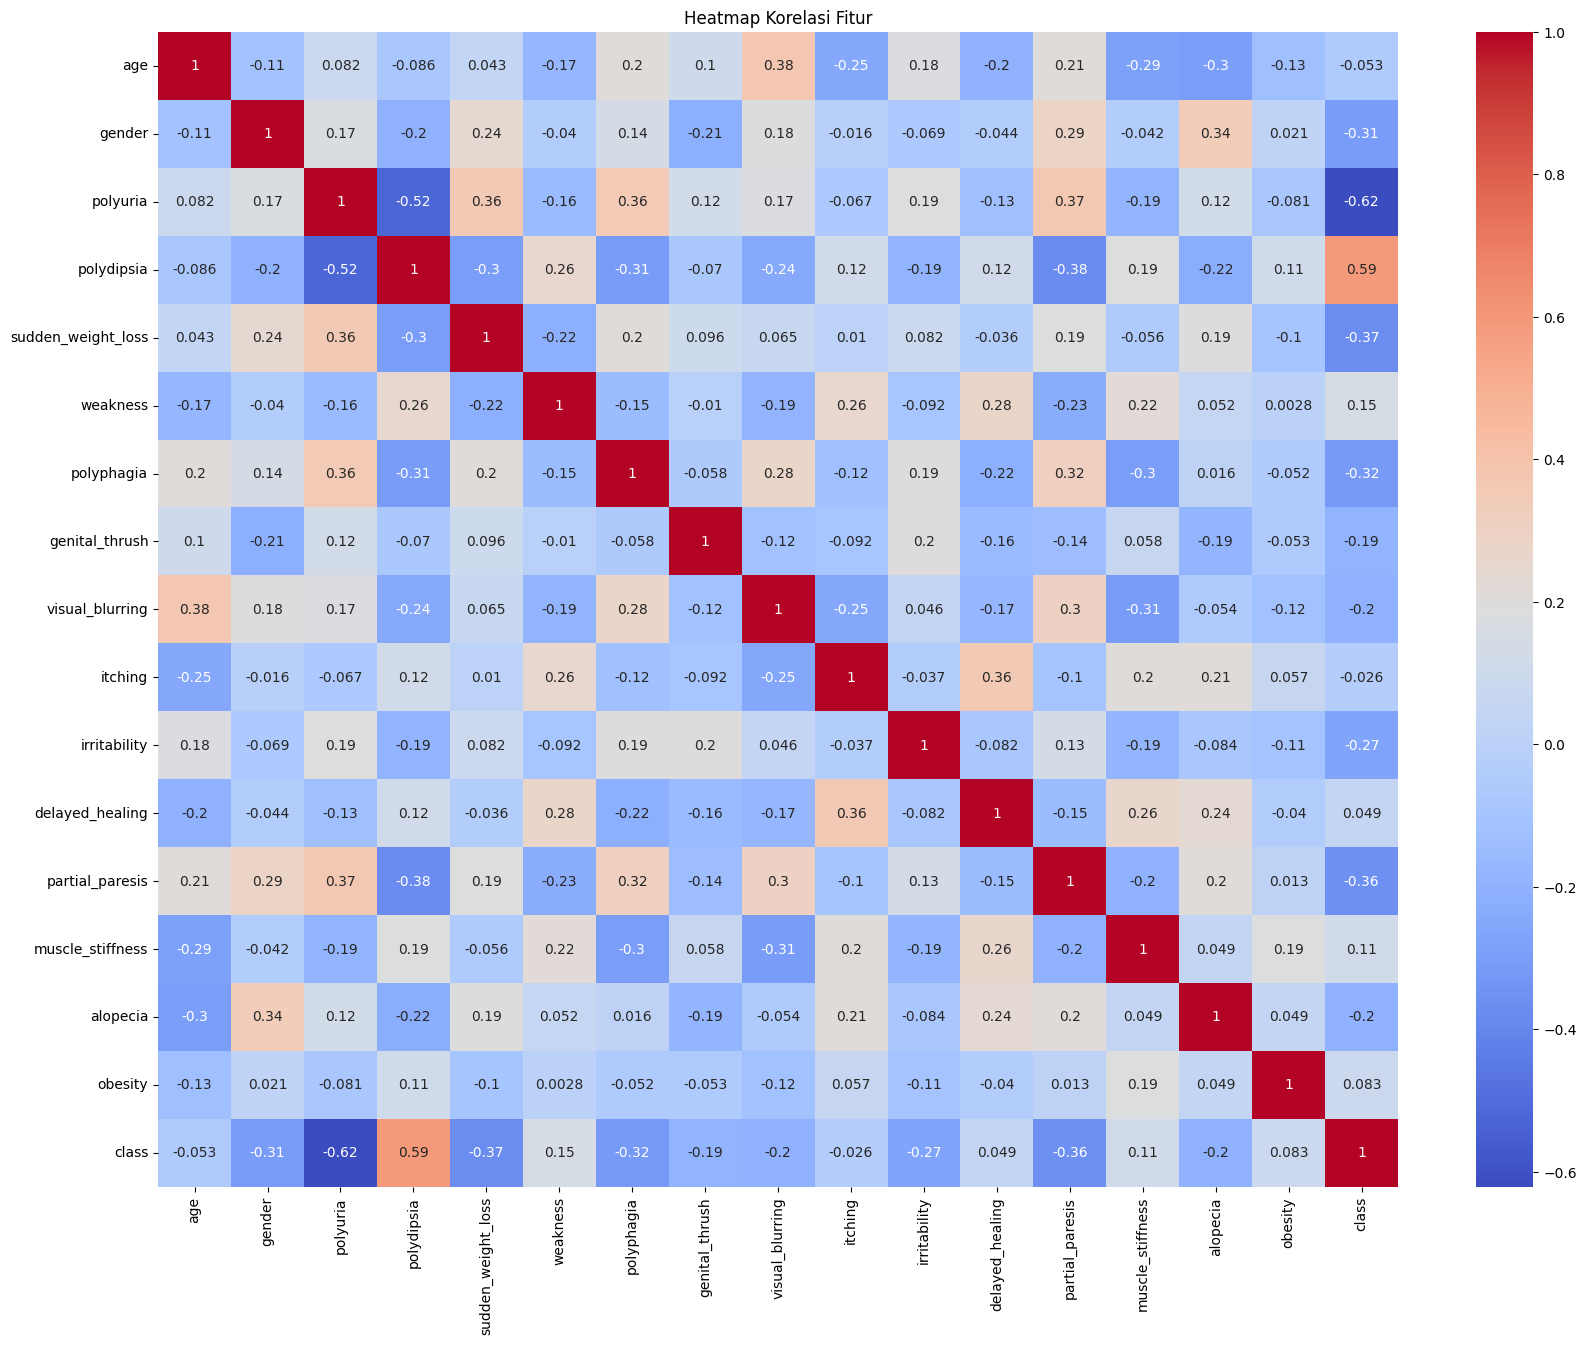

In [72]:
# membuat visualisasi heatmap korelasi fitur

plt.figure(figsize=(20, 15))

sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap Korelasi Fitur")
plt.show()

In [73]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None 

In [74]:
class DecisionTree:
    def __init__(self, n_features, min_best_split = 2, max_depth = 5):
        self.min_best_split = min_best_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root=None
    
    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._growing_tree(X, y, depth=0)

    def _growing_tree(self, X, y, depth=0):
        n_sample, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_sample < self.min_best_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        best_feature, best_thresh = self.find_best_split(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        left = self._growing_tree(X[left_idxs], y[left_idxs], depth+1)
        right = self._growing_tree(X[right_idxs], y[right_idxs], depth+1)

        return Node(best_feature, best_thresh, left, right)
        
    def _most_common_label(self, y):
        from collections import Counter
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def find_best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)

        left_idx, right_idx = self._split(X_column, threshold)
        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idx), len(right_idx)
        e_l, e_r = self._entropy(y[left_idx]), self._entropy(y[right_idx])

        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_threshold):
        left_idxs = np.argwhere(X_column <= split_threshold).flatten()
        right_idxs = np.argwhere(X_column > split_threshold).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        p = counts / counts.sum()
        return -np.sum(p * np.log(p))


    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
        

In [75]:
def train_test_split(X, y, test_size=20, random_state = None):
    if random_state is not None:
        np.random.seed(random_state)
        
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size / 100)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    return X_train, X_test, y_train, y_test

In [76]:
X = df.drop('class', axis=1).values
y = df['class'].values
idx_polydipsia = df.columns.get_loc('polydipsia')

y = y.astype(int)

X = X.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X=X, y=y, test_size=20, random_state=42)

classify = DecisionTree(n_features=None, min_best_split=5, max_depth=4)
classify.fit(X_train, y_train)

predictions = classify.predict(X_test)

print(classify._entropy(y))
print(classify._information_gain(y, X[:, idx_polydipsia], 0))

def accuracy(y_test, predictions):
    return np.sum(y_test == predictions) / len(y_test)

acc = accuracy(y_test, predictions)
print(f"Accuracy: {acc:.4f} ({acc*100:.2f}%)")

0.6197049935943181
0.20553686920559466
Accuracy: 0.7800 (78.00%)


In [77]:
def confusion_matrix(y_true, y_pred):
    tp, tn, fp, fn = 0, 0, 0, 0

    for real, pred in zip(y_true, y_pred):
        if real == 1 and pred == 1:
            tp += 1
        elif real == 0 and pred == 0:
            tn += 1
        elif real == 0 and pred == 1:
            fp += 1
        elif real == 1 and pred == 0:
            fn += 1

    return [[tp, fn], [fp, tn]]

In [78]:
confusion_matrix(y_test, y_train)

[[5, 10], [12, 23]]

In [79]:
def count_metrics(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    tp, fn = matrix[0]
    fp, tn = matrix[1]

    akurasi = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return akurasi, precision, recall, f1_score

In [80]:
count_metrics(y_test, predictions)

(0.78, 0.7, 0.4666666666666667, 0.56)

In [81]:
def plot_tree(tree, feature_names=None):
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.axis("off")

    def _plot(node, x, y, dx):
        if node.value is not None:
            ax.text(
                x, y,
                f"Leaf\nClass={node.value}",
                ha='center', va='center',
                bbox=dict(boxstyle="round", fc="lightgreen")
            )
            return

        feature_name = (
            feature_names[node.feature]
            if feature_names is not None
            else f"X[{node.feature}]"
        )

        ax.text(
            x, y,
            f"{feature_name} ≤ {node.threshold:.2f}",
            ha='center', va='center',
            bbox=dict(boxstyle="round", fc="lightblue")
        )

        ax.plot([x, x - dx], [y - 0.1, y - 0.25], 'k-')
        _plot(node.left, x - dx, y - 0.3, dx / 2)

        ax.plot([x, x + dx], [y - 0.1, y - 0.25], 'k-')
        _plot(node.right, x + dx, y - 0.3, dx / 2)

    _plot(tree.root, x=0.5, y=1.0, dx=0.25)
    plt.show()


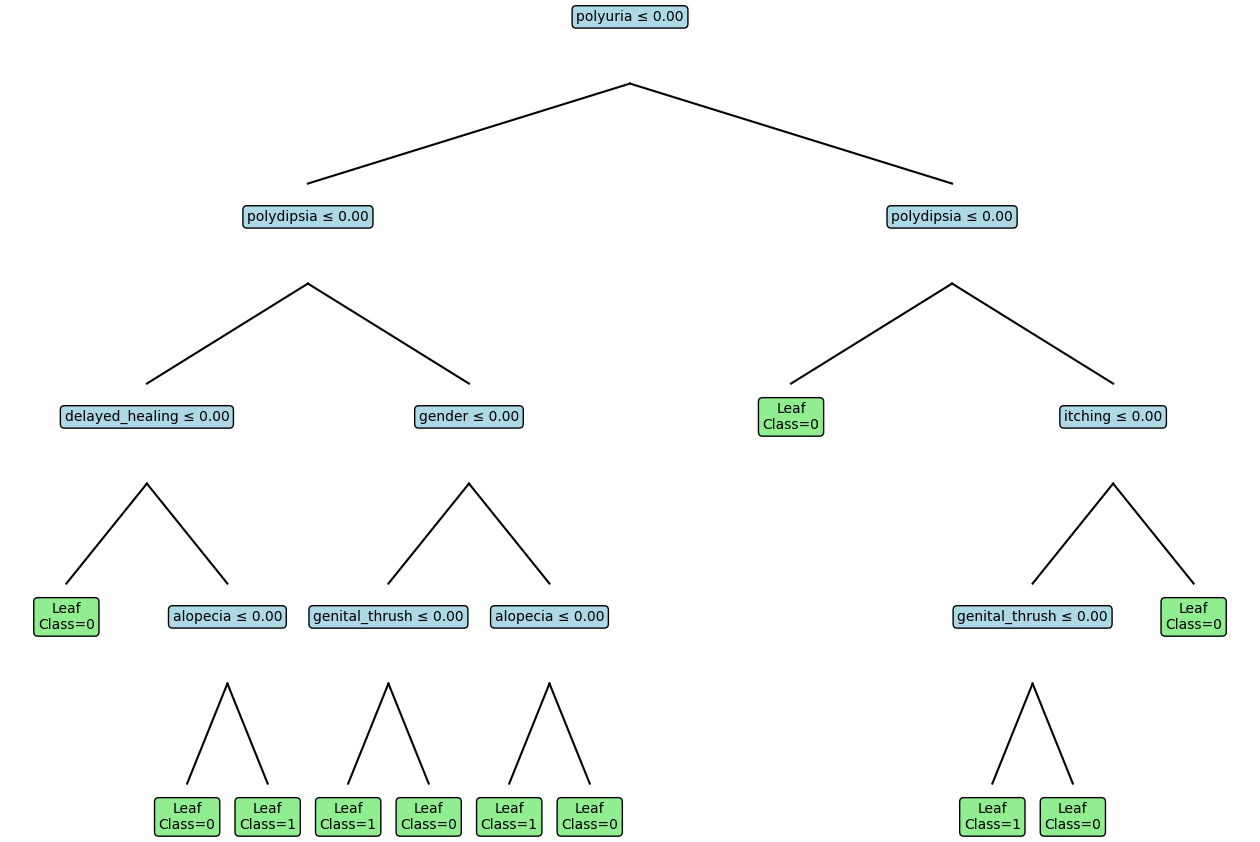

In [82]:
feature_names = df.drop('class', axis=1).columns.tolist()
plot_tree(classify, feature_names)


# GUI

In [83]:
import tkinter as tk
from tkinter import ttk


class GUI:
    def __init__(self, root, tabCtrl, feature_columns):
        self.root = root
        self.root.geometry("500x650")
        self.root.configure(bg="#f1f5f9")
        self.root.title("GUI Prediksi Diabetes")
        self.tabCtrl = tabCtrl
        self.classifier = classify
        self.feature_columns = feature_columns  # Referensi ke global feature_columns
        self.feature_order = [
            "Polyuria",
            "Polydipsia",
            "Sudden Weight Loss",
            "Weakness",
            "Polyphagia",
            "Visual Blurring",
            "Delayed Healing",
        ]
        self.plt = plt

        self.header_font = ("Segoe UI", 18, "bold")
        self.label_font = ("Inter", 10)
        self.entry_font = ("Inter", 11)
        self.result_font = ("Inter", 16, "bold")

        self.setup_ui()

    def make_prediction(self):
        gui_input_values = []
        for feature in self.feature_order:
            gui_input_values.append(self.inputs[feature].get())

        gui_features_lower = [f.lower().replace(" ", "_") for f in self.feature_order]

        full_input = np.zeros(len(self.feature_columns))

        for i, col in enumerate(self.feature_columns):
            if col in gui_features_lower:
                gui_idx = gui_features_lower.index(col)
                full_input[i] = gui_input_values[gui_idx]
            else:
                full_input[i] = 0

        input_array = np.array([full_input], dtype=float)
        prediction = self.classifier.predict(input_array)[0]
        result_text = (
            "Positive (Diabetes)" if prediction == 1 else "Negative (Tidak Diabetes)"
        )
        result_color = "#d32f2f" if prediction == 1 else "#388e3c"

        self.status_label.config(text="Status: Prediksi Selesai", fg="#4caf50")
        self.result_label.config(text=result_text, fg=result_color)

    def setup_ui(self):
        header_frame = tk.Frame(self.root, bg="#4caf50", pady=25)
        header_frame.pack(fill="x")

        tk.Label(
            header_frame,
            text="Prediksi Label Dataset",
            font=self.header_font,
            fg="white",
            bg="#4caf50",
        ).pack()

        tk.Label(
            header_frame,
            text="Simulasi Input Data Diabetes Untuk Model Machine Learning",
            font=("Segoe UI", 9),
            fg="#FFFFFF",
            bg="#4caf50",
        ).pack()

        # main container
        # TAB 1
        main_frame = tk.Frame(self.tabCtrl, bg="#f1f5f9")
        self.tabCtrl.add(main_frame, text="Prediksi")

        tk.Label(
            main_frame,
            text="Masukan Parameter Data:",
            font=("Inter", 10, "bold"),
            bg="#f1f5f9",
            fg="#1c2b36",
        ).pack(anchor="w", pady=(0, 10))

        self.inputs = {}
        features = [
            "Polyuria",
            "Polydipsia",
            "Sudden Weight Loss",
            "Weakness",
            "Polyphagia",
            "Visual Blurring",
            "Delayed Healing",
        ]

        form_container = tk.Frame(main_frame, bg="#f1f5f9")
        form_container.pack(fill="both", expand=True)

        for i, feature in enumerate(features):
            row = i // 2
            col = i % 2

            field_container = tk.Frame(form_container, bg="#f1f5f9")
            field_container.grid(row=row, column=col, padx=10, pady=8, sticky="ew")

            tk.Label(
                field_container,
                text=feature,
                font=self.label_font,
                bg="#f1f5f9",
                fg="#1c2b36",
            ).pack(anchor="w")

            form_container.columnconfigure(0, weight=1)
            form_container.columnconfigure(1, weight=1)

            var = tk.IntVar(value=0)

            entry = ttk.Checkbutton(
                field_container, variable=var, onvalue=1, offvalue=0
            )
            entry.pack(fill="x", padx=2, ipady=2, pady=(2, 0))

            self.inputs[feature] = var

        # tombol prediksi
        predict_btn = tk.Button(
            main_frame,
            text="JALANKAN PREDIKSI DIABETES",
            command=self.make_prediction,
            bg="#16a085",
            fg="white",
            font=("Segoe UI", 11, "bold"),
            activebackground="#7b7b7b",
            activeforeground="white",
            cursor="hand2",
            relief="flat",
            pady=12,
            padx=10,
        )
        predict_btn.pack(fill="x", pady=25)

        self.result_container = tk.LabelFrame(
            main_frame,
            text=" OUTPUT SISTEM ",
            font=("Segoe UI", 9, "italic"),
            bg="#ffffff",
            fg="#757575",
            padx=15,
            pady=15,
        )
        self.result_container.pack(fill="x")

        self.status_label = tk.Label(
            self.result_container,
            text="Status: Masukan Data Anda",
            font=("Segoe UI", 9),
            bg="#ffffff",
            fg="#9e9e9e",
        )
        self.status_label.pack()

        self.result_label = tk.Label(
            self.result_container,
            text="---",
            font=self.result_font,
            bg="#ffffff",
            fg="#212121",
        )
        self.result_label.pack(pady=10)

        # end tab 1

        # TAB 2
        second_frame = tk.Frame(self.tabCtrl, bg="#f1f5f9")
        self.tabCtrl.add(second_frame, text="Tentang")

        matrix = confusion_matrix(y_test, predictions)
        tp, fn = matrix[0]
        fp, tn = matrix[1]

        total_correct = tp + tn
        total_wrong = fp + fn

        akurasi, precision, recall, f1_score = count_metrics(y_test, predictions)

        model_information_items = [
            f"Accuracy       : {akurasi * 100:.2f}%",
            f"Precision      : {precision:.4f}",
            f"Correct Value  : {total_correct} data",
            f"Wrong Value    : {total_wrong} data",
        ]

        # container utama tab
        content_container = tk.Frame(second_frame, bg="#f1f5f9", padx=15, pady=15)
        content_container.pack(fill="both", expand=True)

        # =========================
        # SECTION 1: INFORMASI MODEL
        # =========================
        info_frame = tk.LabelFrame(
            content_container,
            text=" Informasi Model ",
            font=("Segoe UI", 10, "bold"),
            bg="#ffffff",
            fg="#4caf50",
            padx=15,
            pady=10,
        )
        info_frame.pack(fill="x", pady=(0, 15))

        model_evaluation_items = [
            f"Training Data : {len(X_train) / df.shape[0] * 100:.0f}%",
            f"Testing Data  : {len(X_test) / df.shape[0] * 100:.0f}%",
            "Decision Tree Depth : 5",
        ]

        for i, item in enumerate(model_evaluation_items):
            row = i // 2
            col = i % 2

            item_frame = tk.Frame(info_frame, bg="#ffffff")
            item_frame.grid(row=row, column=col, padx=10, pady=6, sticky="w")

            tk.Label(
                item_frame, text=item, font=self.label_font, bg="#ffffff", fg="#1c2b36"
            ).pack(anchor="w")

        info_frame.columnconfigure(0, weight=1)
        info_frame.columnconfigure(1, weight=1)

        # =========================
        # SECTION 2: EVALUASI MODEL
        # =========================
        eval_frame = tk.LabelFrame(
            content_container,
            text=" Evaluasi Model ",
            font=("Segoe UI", 10, "bold"),
            bg="#ffffff",
            fg="#4caf50",
            padx=15,
            pady=10,
        )
        eval_frame.pack(fill="x")

        for i, item in enumerate(model_information_items):
            row = i // 2
            col = i % 2

            item_frame = tk.Frame(eval_frame, bg="#ffffff")
            item_frame.grid(row=row, column=col, padx=10, pady=6, sticky="w")

            tk.Label(
                item_frame, text=item, font=self.label_font, bg="#ffffff", fg="#1c2b36"
            ).pack(anchor="w")

        eval_frame.columnconfigure(0, weight=1)
        eval_frame.columnconfigure(1, weight=1)

        # TAB 3
        third_frame = tk.Frame(self.tabCtrl, bg="#f1f5f9")
        self.tabCtrl.add(third_frame, text="Data Visualization")

        container = tk.Frame(third_frame, bg="#f1f5f9")
        container.pack(fill="both", expand=True)

        scroll_canvas = tk.Canvas(container, bg="#f1f5f9", highlightthickness=0)
        scrollbar = ttk.Scrollbar(
            container, orient="vertical", command=scroll_canvas.yview
        )

        scrollbar_frame = tk.Frame(scroll_canvas, bg="#f1f5f9")

        scrollbar_frame.bind(
            "<Configure>",
            lambda e: scroll_canvas.configure(scrollregion=scroll_canvas.bbox("all")),
        )

        scroll_canvas.create_window((0, 0), window=scrollbar_frame, anchor="nw")
        scroll_canvas.configure(yscrollcommand=scrollbar.set)

        scroll_canvas.pack(side="left", fill="both", expand=True)
        scrollbar.pack(side="right", fill="y")

        def create_section(parent, title):
            section = tk.Frame(parent, bg="#f1f5f9")
            section.pack(fill="x", padx=20, pady=(20, 10))

            tk.Label(
                section,
                text=title,
                font=("Segoe UI", 11, "bold"),
                bg="#f1f5f9",
                fg="#1c2b36",
            ).pack(anchor="w")

            return section

        def create_card(parent):
            card = tk.Frame(parent, bg="white", padx=10, pady=10)
            card.pack(fill="x", pady=10)
            return card

        # section data duplikat
        section_quality = create_section(scrollbar_frame, "Data Quality")
        card_duplicate = create_card(section_quality)

        fig_dup = self.plt.Figure(figsize=(6, 4), dpi=100)
        ax_dup = fig_dup.add_subplot(111)

        res = sns.barplot(
            x=["Duplikat", "Tidak Duplikat"],
            y=[count_duplicate, non_duplicate],
            ax=ax_dup,
        )

        for i, p in enumerate(res.patches):
            res.text(
                p.get_x() + p.get_width() / 2,
                p.get_height(),
                f"{precentages[i]:.1f}%",
                ha="center",
                va="bottom",
            )

        canvas_dup = FigureCanvasTkAgg(fig_dup, master=card_duplicate)
        canvas_dup.draw()
        canvas_dup.get_tk_widget().pack(fill="both", expand=True)

        # section distribusi usia dan gender
        section_dist = create_section(scrollbar_frame, "Distribusi Usia & Gender")
        card_age_gender = create_card(section_dist)

        fig_age = self.plt.Figure(figsize=(6, 5), dpi=100)
        ax_age = fig_age.add_subplot(111)

        sns.barplot(data=df, y="age", x="class", hue="gender", ax=ax_age)
        ax_age.set_xticklabels(["Positive", "Negative"])
        handles, labels = ax_age.get_legend_handles_labels()
        gender_labels = ["Male", "Female"]

        ax_age.legend(handles, gender_labels, title="Gender")

        canvas_age = FigureCanvasTkAgg(fig_age, master=card_age_gender)
        canvas_age.draw()
        canvas_age.get_tk_widget().pack(fill="both", expand=True)

        # section distribusi kolum pie chart
        section_pie = create_section(
            scrollbar_frame, "Pie Chart Hasil Column Dengan Kondisi Positive Diabetes"
        )

        pie_container = tk.Frame(section_pie, bg="#f1f5f9")
        pie_container.pack(fill="x")

        for col in range(2):
            pie_container.columnconfigure(col, weight=1)

        categorical_cols = [
            col for col in df.columns if df[col].dtype == "object" and col != "class"
        ]

        for i, feature in enumerate(categorical_cols):
            row = i // 2
            col = i % 2

            pie_card = tk.Frame(pie_container, bg="white", padx=10, pady=10)
            pie_card.grid(row=row, column=col, padx=10, pady=10, sticky="nsew")

            fig_pie = self.plt.Figure(figsize=(4, 4), dpi=100)
            ax_pie = fig_pie.add_subplot(111)

            count_positive = df[df["class"] == "Positive"][feature].value_counts()

            ax_pie.pie(count_positive, autopct="%1.1f%%", startangle=90)

            legend = list(count_positive.index)

            ax_pie.legend(legend)
            ax_pie.set_title(feature)

            canvas_pie = FigureCanvasTkAgg(fig_pie, master=pie_card)
            canvas_pie.draw()
            canvas_pie.get_tk_widget().pack(fill="both", expand=True)

        section_corr = create_section(scrollbar_frame, "Korelasi Fitur")
        card_heatmap = create_card(section_corr)

        fig_heat = self.plt.Figure(figsize=(12, 8), dpi=100)
        ax_heat = fig_heat.add_subplot(111)

        sns.heatmap(df.corr(), annot=True, cmap="coolwarm", ax=ax_heat)

        canvas_heat = FigureCanvasTkAgg(fig_heat, master=card_heatmap)
        canvas_heat.draw()
        canvas_heat.get_tk_widget().pack(fill="both", expand=True)


if __name__ == "__main__":
    root = tk.Tk()

    tabCtrl = ttk.Notebook(root)
    tabCtrl.pack(fill="both", expand=True)

    feat = df.columns
    app = GUI(root, tabCtrl, feat)

    root.mainloop()

C:\Users\USER\AppData\Local\Temp\ipykernel_13884\1902727269.py:344: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_age.set_xticklabels(["Positive", "Negative"])
